In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import quandl
API='ev8wgXS3LGQgZuHp6Bvm'
quandl.ApiConfig.api_key = API

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [2]:
RANDOM_SEED=42
window=60

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
stock=quandl.get('WIKI/MSFT',start_date="2010-01-01",end_date="2018-01-01")
split=int(len(stock)*0.8)

In [4]:
# Importing the training set
dataset_train = stock.iloc[:split,:]
training_set = dataset_train.iloc[:,3].values.reshape(-1, 1)

# Feature Scaling

sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(window, training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))


In [5]:
regressor = Sequential()


regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

regressor.add(Dense(units = 1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)


Epoch 1/100
49/49 [==============================] - 12s 74ms/step - loss: 0.0634
Epoch 2/100
49/49 [==============================] - 3s 62ms/step - loss: 0.0050
Epoch 3/100
49/49 [==============================] - 3s 66ms/step - loss: 0.0049
Epoch 4/100
49/49 [==============================] - 3s 62ms/step - loss: 0.0048
Epoch 5/100
49/49 [==============================] - 3s 64ms/step - loss: 0.0038
Epoch 6/100
49/49 [==============================] - 3s 66ms/step - loss: 0.0043
Epoch 7/100
49/49 [==============================] - 3s 64ms/step - loss: 0.0039
Epoch 8/100
49/49 [==============================] - 4s 79ms/step - loss: 0.0042
Epoch 9/100
49/49 [==============================] - 4s 91ms/step - loss: 0.0040
Epoch 10/100
49/49 [==============================] - 5s 95ms/step - loss: 0.0037
Epoch 11/100
49/49 [==============================] - 4s 79ms/step - loss: 0.0034
Epoch 12/100
49/49 [==============================] - 4s 90ms/step - loss: 0.0035
Epoch 13/100
49/49 [====

In [11]:
dataset_test = stock.iloc[split:,:]
real_stock_price = dataset_test.iloc[:, 3].values.reshape(-1,1)

# Getting the predicted stock price of 2017
dataset_total = pd.concat((dataset_train['Close'], dataset_test['Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - window:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(window, 260):
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [7]:
X_test.shape

(140, 60, 1)

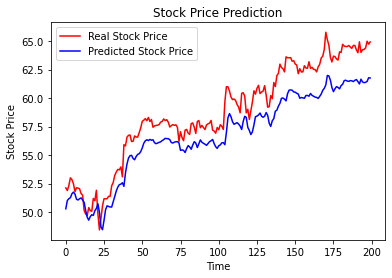

In [12]:
# Visualising the results
plt.plot(real_stock_price[:200], color = 'red', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()